# LCPA 23-24 - "Hierarchical mergers of binary black holes"


<center><h1>Group 07</h1></center>


<center><style>
table {
    font-size: 24px;
}
</style></center>

| Last Name          | First Name            |Student Number|
|--------------------|-----------------------|----------------|
| Bertinelli         | Gabriele              |2103359         |
| Boccanera          | Eugenia               |                |
| Cacciola           | Martina               |2097476         |
| Lovato             | Matteo                |                |           


## Import modules

In [1]:
import numpy as np
import pandas as pd
import polars as pl 

import matplotlib.pyplot as plt
import hvplot
import seaborn as sns

import numpy.typing as npt
from typing import Optional, Tuple, Callable, Union, List

%matplotlib inline

## Dataset creation

In [2]:
def create_dataset(path: str, folders: List[str], mets: List[str], cols: List[str]) -> pl.DataFrame:

    """
    Function that takes in input a list of folders and a list of metallicities.
    It returns a polars lazy DataFrame with all the data from the folders and metallicities.

    :params path: path to the data parent folder (remember to add the final '/')
    :params folders: list of selected folders
    :params mets: list of selected metallicities
    :params cols: list of selected columns original names
    :return: a `polars` DataFrame with all the data from the folders and metallicities
    """

    name = 'nth_generation.txt'

    col_name = ['c' + str(i) for i in range(28)]

    for i in range(len(folders)):
        for j in range(len(mets)):

            
            file_q = pl.scan_csv(path + folders[i] + '/Dyn/' + 
                                mets[j] + '/' + name, 
                                separator = ' ', has_header=True,
                                new_columns = col_name).select(cols) # select bold columns -> most important for this analysis
            
            
            met = pl.Series([float(mets[j]) for k in range(file_q.collect().height)]) # add metallicity column

            # univocal ID given by the original ID . metallicity folder . hosting obj folder
            new_id = pl.Series(file_q.select(pl.col('c0')).cast(pl.String).collect() + '.' + str(j) + '.' + str(i))#.cast(pl.Float64)

            # hosting object label set: 0 -> GC, 1 -> nSC, 2 -> ySC
            label = pl.Series([i for _ in range(file_q.collect().height)])

            file_q = file_q.with_columns(label.alias('label'), met.alias('met'), new_id.alias('c0')) 

            if i == 0 and j==0:
                df = file_q.collect()
                
            else:
                
                df = df.vstack(file_q.collect())

    return df


def rename_columns(df: pl.DataFrame, new_cols: List[str]) -> pl.DataFrame:
    """
    Function that takes in input a DataFrame and a list of new column names (apart from the last two columns).
    It returns a DataFrame with renamed columns.

    :params df: input `polars` or `pandas` DataFrame 
    :params new_cols: list of new column names
    :return: a `polars` or `pandas` DataFrame with renamed columns
    """
    old_cols = df.columns

    rename_dict = {old_cols[i]: new_cols[i] for i in range(len(old_cols)-2)}
    df = df.rename(rename_dict)

    return df


def get_label_ngen(df: pl.DataFrame) -> pl.DataFrame:

    """
    Function that takes in input a DataFrame and returns a new column with the label for the nth generation.
     - 0 if the ID is unique, meaning that the binary systems did not evolve further (from the 2nd generation); 
     - 1 if the ID is not unique, meaning that the binary systems evolved further (from the 2nd generation).

    :param df: DataFrame
    :return: DataFrame
    """
    id_counts = df.group_by('ID').agg(pl.count('ID').alias('count'))

    # Join the count information back to the original DataFrame
    df = df.join(id_counts, on='ID', how='left')

    # Add the new column based on your condition
    df = df.with_columns(
        pl.when(df['count'] > 1)
        .then(1)
        .otherwise(0)
        .alias('label_ngen')
    )

    # Drop the temporary count column if needed
    df = df.drop('count')

    return df

In [3]:
path = './data/'

folder = ['GC_chi01_output_noclusterevolv', 'NSC_chi01_output_noclusterevolv',
               'YSC_chi01_output_noclusterevolv']
    
metallicity = ['0.0002', '0.002', '0.02', '0.0004', '0.004', '0.006', '0.0008',
                   '0.008', '0.0012', '0.012', '0.0016', '0.016']

cols = ['c0', 'c1', 'c2', 'c3', 'c4', 'c7', 'c8', 'c9', 'c13', 'c15', 'c16', 'c17', 'c25', 'c27'] # select bold columns -> most important for this analysis

new_cols = ['ID', 'bh_mass1', 'bh_mass2', 'spin1', 'spin2', 'semimajor', 'i_ecc', 'time_dyn', 'time_merge', 
'remnant_mass', 'remnant_spin', 'escape_vel', 'cluster_mass', 'n_gen']

In [4]:
df = create_dataset(path, folder, metallicity, cols)

df = rename_columns(df, new_cols)

df = get_label_ngen(df)

In [5]:
df

ID,bh_mass1,bh_mass2,spin1,spin2,semimajor,i_ecc,time_dyn,time_merge,remnant_mass,remnant_spin,escape_vel,cluster_mass,n_gen,met,label,label_ngen
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i64,i32
"""2.0.0""",28.497396,23.848129,0.734705,0.014536,118.322458,0.660875,73.920947,1746.620064,49.029268,0.816124,43.17523,456627.739325,2,0.0002,0,0
"""18.0.0""",38.172095,29.913274,0.753993,0.161852,378.031535,0.406799,38.064151,1712.47759,63.511846,0.840459,42.843056,375550.638468,2,0.0002,0,0
"""34.0.0""",60.53033,53.519905,0.720625,0.162188,608.965749,0.936663,240.687784,2461.291832,106.560909,0.825812,118.780296,5.4067e6,2,0.0002,0,0
"""38.0.0""",14.480868,13.043004,0.725751,0.111623,219.843013,0.361773,691.059977,7757.376544,25.747022,0.81898,76.422227,1.6841e6,2,0.0002,0,0
"""103.0.0""",19.224383,15.611048,0.742771,0.208234,28.765131,0.490608,2000.834621,7287.34974,32.475861,0.840732,103.880881,4.2546e6,2,0.0002,0,0
"""113.0.0""",33.843926,32.023636,0.726826,0.232168,1.89279,0.208056,649.979242,2821.696673,61.458894,0.829968,70.835751,2.9658e6,2,0.0002,0,0
"""135.0.0""",73.377878,35.020559,0.760173,0.234082,1.342094,0.425407,6.66764,256.26748,101.642414,0.866648,31.446697,137106.259438,2,0.0002,0,0
"""136.0.0""",52.235448,31.237802,0.724643,0.231708,1.090808,0.795367,106.512338,390.572766,78.029693,0.852859,68.644652,1.4879e6,2,0.0002,0,0
"""138.0.0""",15.353996,13.993469,0.736298,0.30687,10.200153,0.639587,685.172002,2610.79659,27.310871,0.843201,91.269172,2.1241e6,2,0.0002,0,0


In [ ]:
# %%timeit 
# df = create_dataset(path, folders=folder, mets=metallicity)

In [ ]:
import pandas as pd
import numpy as np

def create_dataset_pd(path: str, folders: List[str], mets: List[str]) -> pd.DataFrame:
    """
    Function that takes in input a list of folders and a list of metallicities.
    It returns a pandas DataFrame with all the data from the folders and metallicities.

    :params path: path to the data parent folder (remember to add the final '/')
    :params folders: list of folders
    :params mets: list of metallicities
    :return: a `pandas` DataFrame with all the data from the folders and metallicities
    """

    name = 'nth_generation.txt'
    col_name = ['c' + str(i) for i in range(28)]
    df = pd.DataFrame()

    for i in range(len(folders)):
        for j in range(len(mets)):
            file_path = path + folders[i] + '/Dyn/' + mets[j] + '/' + name
            file_q = pd.read_csv(file_path, sep=' ', names=col_name, header=0, low_memory=False)
            file_q = file_q[['c0', 'c1', 'c2', 'c3', 'c4', 'c9', 'c13', 'c15', 'c16', 'c17', 'c25', 'c27']] # select bold columns -> most important for this analysis
            
            met = pd.Series([float(mets[j]) for _ in range(file_q.shape[0])]) # add metallicity column
            file_q['met'] = met

            # labels set: 0 -> GC, 1 -> nSC, 2 -> ySC
            if i == 0:
                label = pd.Series([0 for _ in range(file_q.shape[0])])
            elif i == 1:
                label = pd.Series([1 for _ in range(file_q.shape[0])])
            elif i == 2:
                label = pd.Series([2 for _ in range(file_q.shape[0])])

            file_q['label'] = label

            df = pd.concat([df, file_q], ignore_index=True)

    return df

In [ ]:
# %%timeit 
# df_pd = create_dataset_pd(path, folders=folder, mets=metallicity)

In [ ]:
#df_n = df.select('c3', 'c4', 'label').sample(n=500, shuffle=True)

In [ ]:
# df_n.plot.scatter(x='c3', y='c4', by='label', alpha=0.8, figsize=(10, 10), muted_alpha=0.1)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tqdm import tqdm
from sklearn.metrics import accuracy_score

df = df.to_pandas()

# Separate majority and minority classes
df_majority = df[df['label_ngen']==df['label_ngen'].value_counts().idxmax()]
df_minority = df[df['label_ngen']==df['label_ngen'].value_counts().idxmin()]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df_minority.shape[0],     # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
print(df_balanced['label_ngen'].value_counts())

# Now let's select 10000 samples
df_sample = df_balanced.sample(n=10000, random_state=1)

# Define features and target
X = df_sample.drop(['ID', 'label', 'n_gen', 'label_ngen'], axis=1)
y = df_sample['label_ngen']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class ProgressRandomForest(RandomForestClassifier):
    def fit(self, X, y):
        super().fit(X, y)
        self.estimators_ = list(tqdm(self.estimators_, desc="Fitting estimators"))
        return self

# Initialize the model
rf = ProgressRandomForest(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

label_ngen
0    402598
1    402598
Name: count, dtype: int64


Fitting estimators: 100%|██████████| 100/100 [00:00<?, ?it/s]


In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate and print confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_mat)

Accuracy: 0.799
Confusion Matrix:
[[872 137]
 [265 726]]


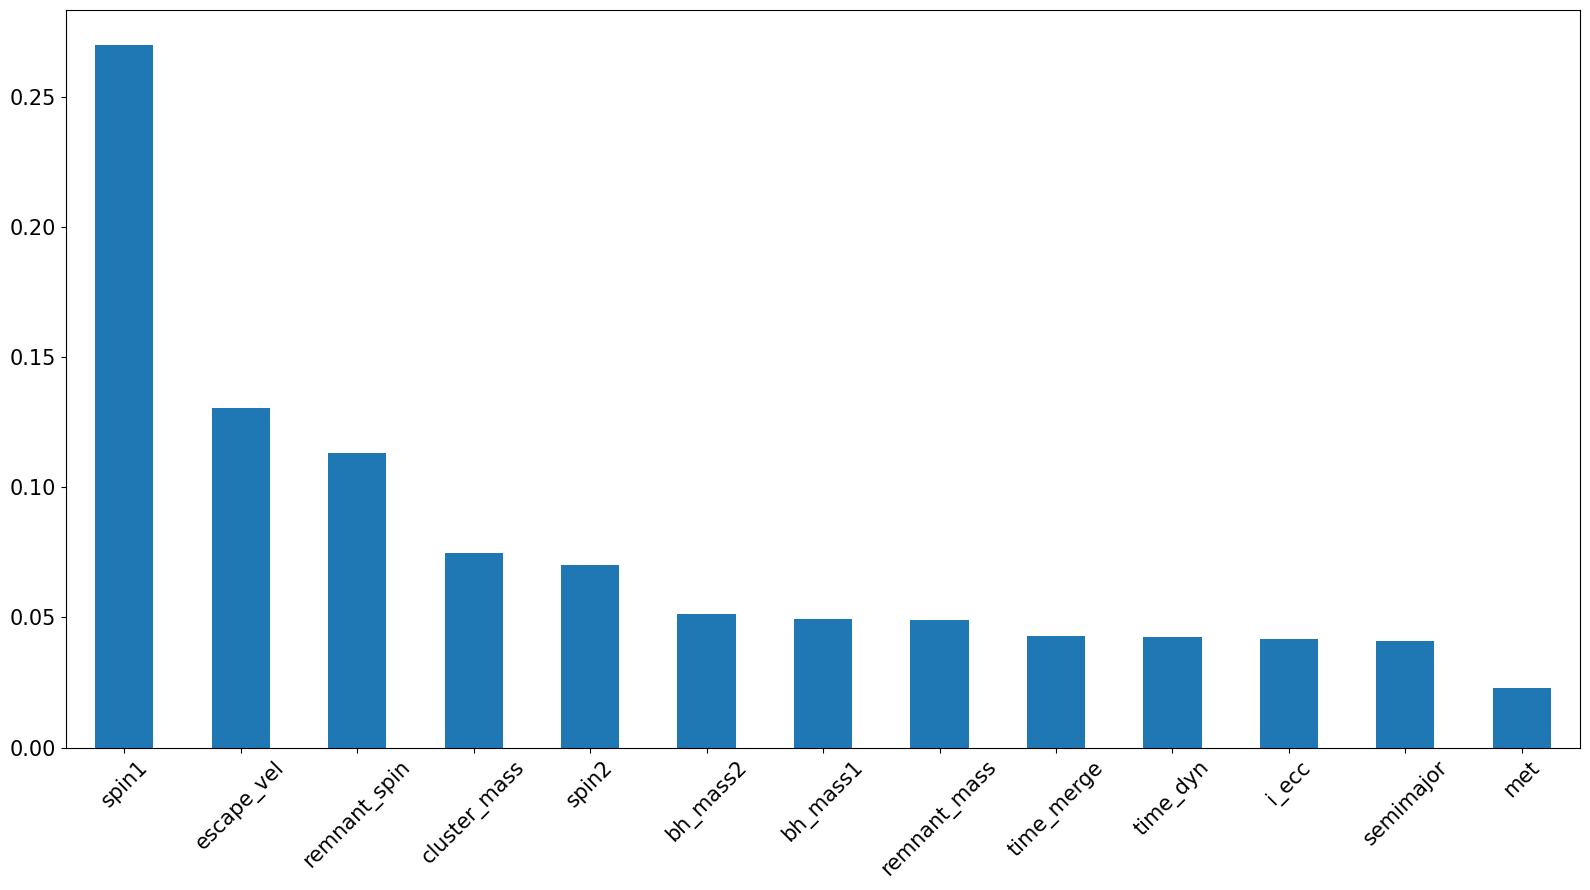

In [7]:
import matplotlib.pyplot as plt

# Get feature importances
importances = rf.feature_importances_

# Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
f_importances = pd.Series(importances, X_train.columns)

# Sort the array in descending order of the importances
f_importances.sort_values(ascending=False, inplace=True)

# Make the bar Plot from f_importances 
f_importances.plot(x='Features', y='Importance', kind='bar', figsize=(16,9), rot=45, fontsize=15)

# Show the plot
plt.tight_layout()
plt.show()

In [14]:
import shap

# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)

# Calculate Shap values
shap_values = explainer.shap_values(X_train[:150].values)

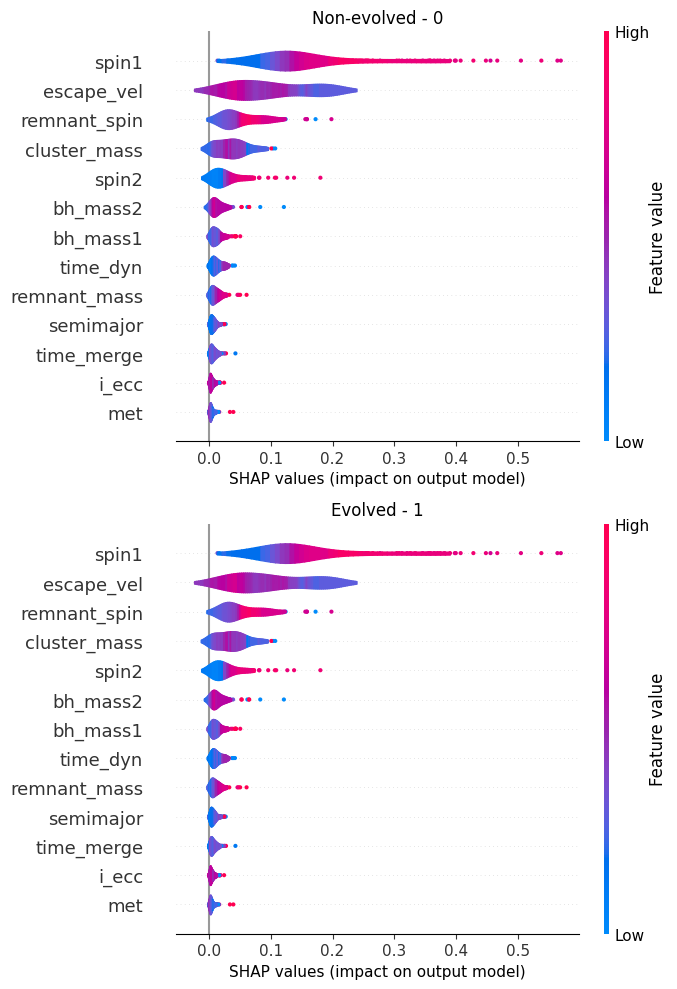

In [14]:
fig = plt.figure()

ax0 = fig.add_subplot(211)
ax0.set_title('Non-evolved - 0')
shap.summary_plot(np.abs(shap_values[0]), X_test[:150], plot_type='violin', show=False)
ax0.set_xlabel('SHAP values (impact on output model)', fontsize=11)



ax1 = fig.add_subplot(212)
ax1.set_title('Evolved - 1')
shap.summary_plot(np.abs(shap_values[1]), X_test[:150], plot_type='violin', show=False)
ax1.set_xlabel('SHAP values (impact on output model)', fontsize=11)


# ax2 = fig.add_subplot(313)
# plt.title('Class 0 - CE')
# shap.summary_plot(shap_values[0], X_test[:150], plot_type='violin', show=False)
# plt.xlabel('SHAP values (impact on output model)', fontsize=11)

plt.subplots_adjust(hspace = 50)
plt.gcf().set_size_inches(7,10)
plt.tight_layout()
plt.show()

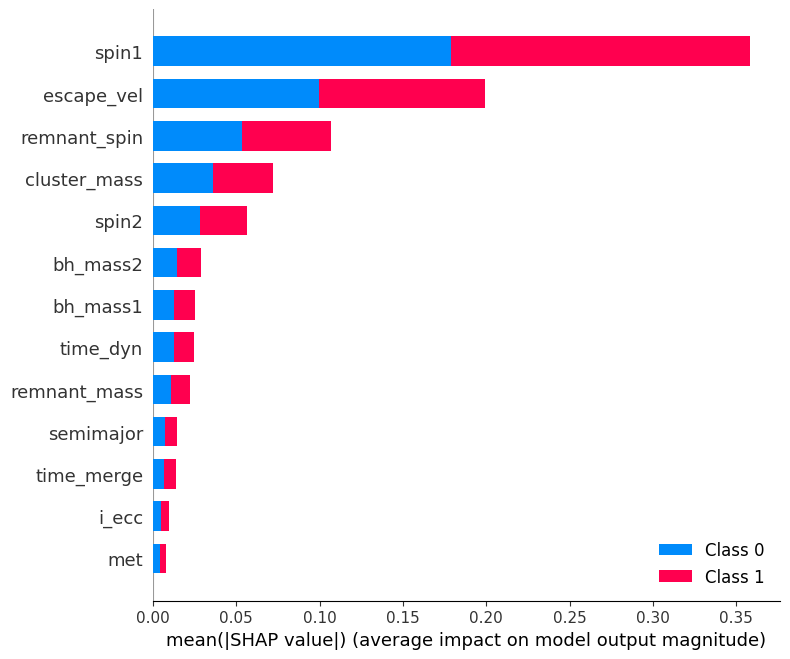

In [7]:
import shap
shap_values = shap.TreeExplainer(rf).shap_values(X_test[:150])
shap.summary_plot(shap_values, X_test[:150])

AttributeError: 'list' object has no attribute 'values'